In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from genericpath import exists
import statistics
import scipy.stats as st

In [2]:
def process_df_for_gantt(df: pd):

    worker_dict = {}

    for row in df.itertuples(index=True, name="Pandas"):
        task_id = str(row.task_id)
        start = row.start_time
        end = row.end_time
        duration = end - start
        host_ip = row.host_ip
        pid = row.pid
        task = row.file_name + "/" + row.column_name
        worker_dict[task_id] = {
            "start": start,
            "end": end,
            "duration": duration,
            "host_ip": host_ip,
            "pid": pid,
            "task": task,
        }

    return worker_dict

In [3]:
def analyze_signle_local_logs_file(
    logs_file_path_name: str = None,
    initial_process_time: float = 0,
    total_process_time: float = 0,
    instance_number:int = 0 ,
    num_unfinished_tasks: int = 0,
    code_templates:str = None,

) -> dict:

    if exists(logs_file_path_name) is False:
        print(f"{logs_file_path_name} does not exist")
        return
    df = pd.read_csv(logs_file_path_name)

    error_task = df[(df["alert_type"] == "SYSTEM_ERROR")]
    num_error_task = len(error_task)

    worker_dict = process_df_for_gantt(df)
    shortest_task = ""
    longest_task = ""
    min_duration = float("inf")
    max_duration = 0
    tasks_durtaion_sum = 0
    average_task_duration = 0
    total_tasks = 0
    min_start = float("inf")
    max_end = 0
    duration = 0
    task_duration_in_parallelism = 0
    efficiency = 0
    for key, value in worker_dict.items():
        # logger.info(f"ip {value['host_ip']} ")
        # logger.info(f"ip {value} ")
        if ("start" in value) is False:
            # logger.warning(f"missing 'start' key in task {key}")
            print(f"missing 'start' key in task {key}")
            continue
        if ("end" in value) is False:
            # logger.warning(f"missing 'end' key in task {key}")
            print(f"missing 'end' key in task {key}")
            continue
        start = float(value["start"])
        end = float(value["end"])
        duration = value["duration"]
        task = value["task"]
        if task == "loop_tasks_status_task":
            continue
        tasks_durtaion_sum += duration
        if start < min_start:
            min_start = start
        if end > max_end:
            max_end = end

        if duration < min_duration:
            min_duration = duration
            shortest_task = task
        if duration > max_duration:
            max_duration = duration
            longest_task = task
        total_tasks += 1
    task_duration_in_parallelism = max_end - min_start
    if total_tasks > 0:
        average_task_duration = tasks_durtaion_sum / total_tasks
    else:
        average_task_duration = tasks_durtaion_sum

    if task_duration_in_parallelism > 0:
        efficiency = int(
            (
                (tasks_durtaion_sum - task_duration_in_parallelism)
                / task_duration_in_parallelism
            )
            * 100
        )

    ip_accumulation_druations = dict()
    # --------------------------
    # calcuate effeciency factor
    # --------------------------
    # step 1 , accumulate the process time of each host_ip/pid
    for key, value in worker_dict.items():
        _duration = float(value["duration"])
        _host_ip = value["host_ip"]
        _pid = value["pid"]
        key = str(_host_ip) + "/" + str(_pid)
        if key in ip_accumulation_druations:
            ip_accumulation_druations[key] += _duration
        else:
            ip_accumulation_druations[key] = _duration

    accumulated_process_duration = 0
    for key, value in ip_accumulation_druations.items():
        accumulated_process_duration += value
    effeciency_of_each_ip_pid = dict()
    effeciencyFactor = 0
    if task_duration_in_parallelism > 0:

        for key, value in ip_accumulation_druations.items():
            effeciency_of_each_ip_pid[key] = value / task_duration_in_parallelism

    if len(ip_accumulation_druations) > 0:
        effeciencyFactor = accumulated_process_duration * 100 / (
            task_duration_in_parallelism * len(ip_accumulation_druations)
        )
    messages_rate = 0
    if task_duration_in_parallelism > 0: 
        messages_rate = 3*total_tasks / task_duration_in_parallelism
    performance_dict = {
        "file": logs_file_path_name,
        "instance_number": instance_number,
        "code_templates": code_templates,
        "total_tasks": total_tasks,
        "average_task_duration": round(average_task_duration, 2),
        "min_duration": round(min_duration, 2),
        "max_duration": round(max_duration, 2),
        "num_error_task": num_error_task,
        "longest_task": longest_task,
        "shortest_task": shortest_task,
        "num_unfinished_tasks": num_unfinished_tasks,
        "task_duration_in_parallelism": round(task_duration_in_parallelism, 2),
        "tasks_durtaion_sum": round(tasks_durtaion_sum, 2),
        "initial_process_time": round(initial_process_time, 2),
        "total_process_time": round(total_process_time, 2),
        "effeciencyFactor": round(effeciencyFactor, 2),
        "messages_rate": round(messages_rate, 2),

    }
    return performance_dict

In [4]:
def get_mean_std_and_upper_lower_of_confidence_interval(data:list = None,alpha:float = 0.95 ) -> dict:
    info = {}
    mean = round(
            statistics.mean(data[:]), 2
        )
    std = round(
        statistics.stdev(data[:]), 2
    )
    lower_confidence_interval, upper_confidence_interval= st.t.interval(alpha=alpha, df=len(data)-1, loc=np.mean(data), scale=st.sem(data))
    info = {
        "mean":mean,
        "std":std,
        "lower_confidence_interval":round(mean-lower_confidence_interval,2),
        "upper_confidence_interval":round(upper_confidence_interval-mean,2)

    }
    return info

# Read log file and convert to dataframe

In [5]:
logs_folder_list = ['./gcd-solar-644-mixed/solardatatools-2','./gcd-solar-644-mixed/solardatatools-4','./gcd-solar-644-mixed/solardatatools-8','./gcd-solar-644-mixed/solardatatools-10','./gcd-solar-644-mixed/solardatatools-16','./gcd-solar-644-mixed/solardatatools-24','./gcd-solar-644-mixed/solardatatools-32']
index = 0
logs_files_list = []

# process log file and convert to performance dict
performance = {}
number_of_message_per_task = 3
for _folder in logs_folder_list:
    index = 0 
    base, path = os.path.split(_folder)
    # print(base, path)
    code_templates, number_instance = path.split("-")
    # print(code_templates,number_instance)
    _per_list = []
    _task_duration_in_parallelism_list = []
    _effeciencyFactor_list = []
    _average_task_duration_list = []
    _messages_rate_list = []
    _normalizing_process_time_list = []
    # _optimal_normalizing_process_time_list = []
    total_tasks = 1
    for _file in os.listdir(_folder):
        filename,extension = os.path.splitext(_file)
        if extension == ".csv":
            _name_comp = filename.split("-")
            if len(_name_comp) > 1 and _name_comp[0] == "logs": 
                logs_file_path_name  = _folder +"/"+_file
                per_dict = analyze_signle_local_logs_file(
                    logs_file_path_name=logs_file_path_name,
                    instance_number = number_instance,
                    initial_process_time=0,
                    total_process_time=0,
                    num_unfinished_tasks=0,
                    code_templates = code_templates,
                )
                # _info = {index : per_dict}
                _task_duration_in_parallelism_list.append(per_dict['task_duration_in_parallelism'])
                _effeciencyFactor_list.append(per_dict['effeciencyFactor'])
                _average_task_duration_list.append(per_dict['average_task_duration'])
                _messages_rate_list.append(per_dict['messages_rate'])
                # _normalizing_process_time_list.append(per_dict['normalizing_process_time'])
                # _optimal_normalizing_process_time_list.append(per_dict['optimal_normalizing_process_time'])
                total_tasks = per_dict['total_tasks']
                index += 1
    duration_in_parallelism_dict = get_mean_std_and_upper_lower_of_confidence_interval(_task_duration_in_parallelism_list)
    average_task_duration_dict = get_mean_std_and_upper_lower_of_confidence_interval(_average_task_duration_list)
    effeciencyFactor_dict =  get_mean_std_and_upper_lower_of_confidence_interval(_effeciencyFactor_list)
    messages_rate_dict = get_mean_std_and_upper_lower_of_confidence_interval(_messages_rate_list)
    # normalizing_process_time_dict = get_mean_std_and_upper_lower_of_confidence_interval(_normalizing_process_time_list)

    _info = {
            'code_templates':code_templates,
            'number_instance':number_instance,
            # '_optimal_normalizing_process_time':_optimal_normalizing_process_time_list,
            "duration_in_parallelism":duration_in_parallelism_dict,
            "effeciencyFactor":effeciencyFactor_dict,
            "average_task_duration":average_task_duration_dict,
            "messages_rate":messages_rate_dict,
            # "normalizing_process_time":normalizing_process_time_dict


    }

    performance[path] = _info


In [6]:
# Get x axis
X_axis = []
for _folder in logs_folder_list:
    base, path = os.path.split(_folder)
    # print(base, path)
    code_templates, number_instance = path.split("-")
    X_axis.append(int(number_instance)*2)


In [7]:
# Get Y 
mean_of_task_duration_in_parallelism_list = []
lower_confidence_interval_of_task_duration_in_parallelism = []
upper_confidence_interval_of_task_duration_in_parallelism = []
mean_of_effeciencyFactor_list = []
lower_confidence_interval_of_effeciencyFactor_list = []
upper_confidence_interval_of_effeciencyFactor_list= []

mean_of_average_task_duration_list = []
lower_confidence_interval_of_average_task_duration_list  = []
upper_confidence_interval_of_average_task_duration_list =  []

mean_of_messages_rate_list = []
lower_confidence_interval_of_messages_rate_list = []
upper_confidence_interval_of_messages_rate_list= []

# mean_of_normalizing_process_time = []
# lower_confidence_mean_of_normalizing_process_time = []
# upper_confidence_mean_of_normalizing_process_time= []
optimal_normalizing_process_time_list = []

for _folder in logs_folder_list:
    base, path = os.path.split(_folder)
    # print(base, path)
    code_templates, number_instance = path.split("-")
    info = performance[path]
    
 
    # print(f'----------> {path}')
    # print(f"info: {info}")
    mean_of_task_duration_in_parallelism_list.append(info['duration_in_parallelism']['mean'])
    lower_confidence_interval_of_task_duration_in_parallelism.append(info['duration_in_parallelism']['lower_confidence_interval'])
    upper_confidence_interval_of_task_duration_in_parallelism.append(info['duration_in_parallelism']['upper_confidence_interval'])

    mean_of_effeciencyFactor_list.append(info['effeciencyFactor']['mean'])
    lower_confidence_interval_of_effeciencyFactor_list.append(info['effeciencyFactor']['lower_confidence_interval'])
    upper_confidence_interval_of_effeciencyFactor_list.append(info['effeciencyFactor']['upper_confidence_interval'])

    
    mean_of_average_task_duration_list.append(performance[path]['average_task_duration']['mean'])
    lower_confidence_interval_of_average_task_duration_list.append(performance[path]['average_task_duration']['lower_confidence_interval'])
    upper_confidence_interval_of_average_task_duration_list.append(performance[path]['average_task_duration']['upper_confidence_interval'])

    
    mean_of_messages_rate_list.append(performance[path]['messages_rate']['mean'])
    lower_confidence_interval_of_messages_rate_list.append(performance[path]['messages_rate']['lower_confidence_interval'])
    upper_confidence_interval_of_messages_rate_list.append(performance[path]['messages_rate']['upper_confidence_interval'])

    optimal_normalizing_process_time = round(1/(int(number_instance)*2),4)
    optimal_normalizing_process_time_list.append(optimal_normalizing_process_time)


acutal_normalizing_process_time_list = []

for index, task_d in enumerate(mean_of_task_duration_in_parallelism_list):
    average_task_duration = mean_of_average_task_duration_list[index]
    # print(task_d,total_tasks,average_task_duration)
    acutal_normalizing_process_time = task_d/ (total_tasks*average_task_duration)
    acutal_normalizing_process_time_list.append(round(acutal_normalizing_process_time,4))
print(acutal_normalizing_process_time_list)
print(optimal_normalizing_process_time_list)

[0.2523, 0.128, 0.0656, 0.0565, 0.0361, 0.0333, 0.031]
[0.25, 0.125, 0.0625, 0.05, 0.0312, 0.0208, 0.0156]


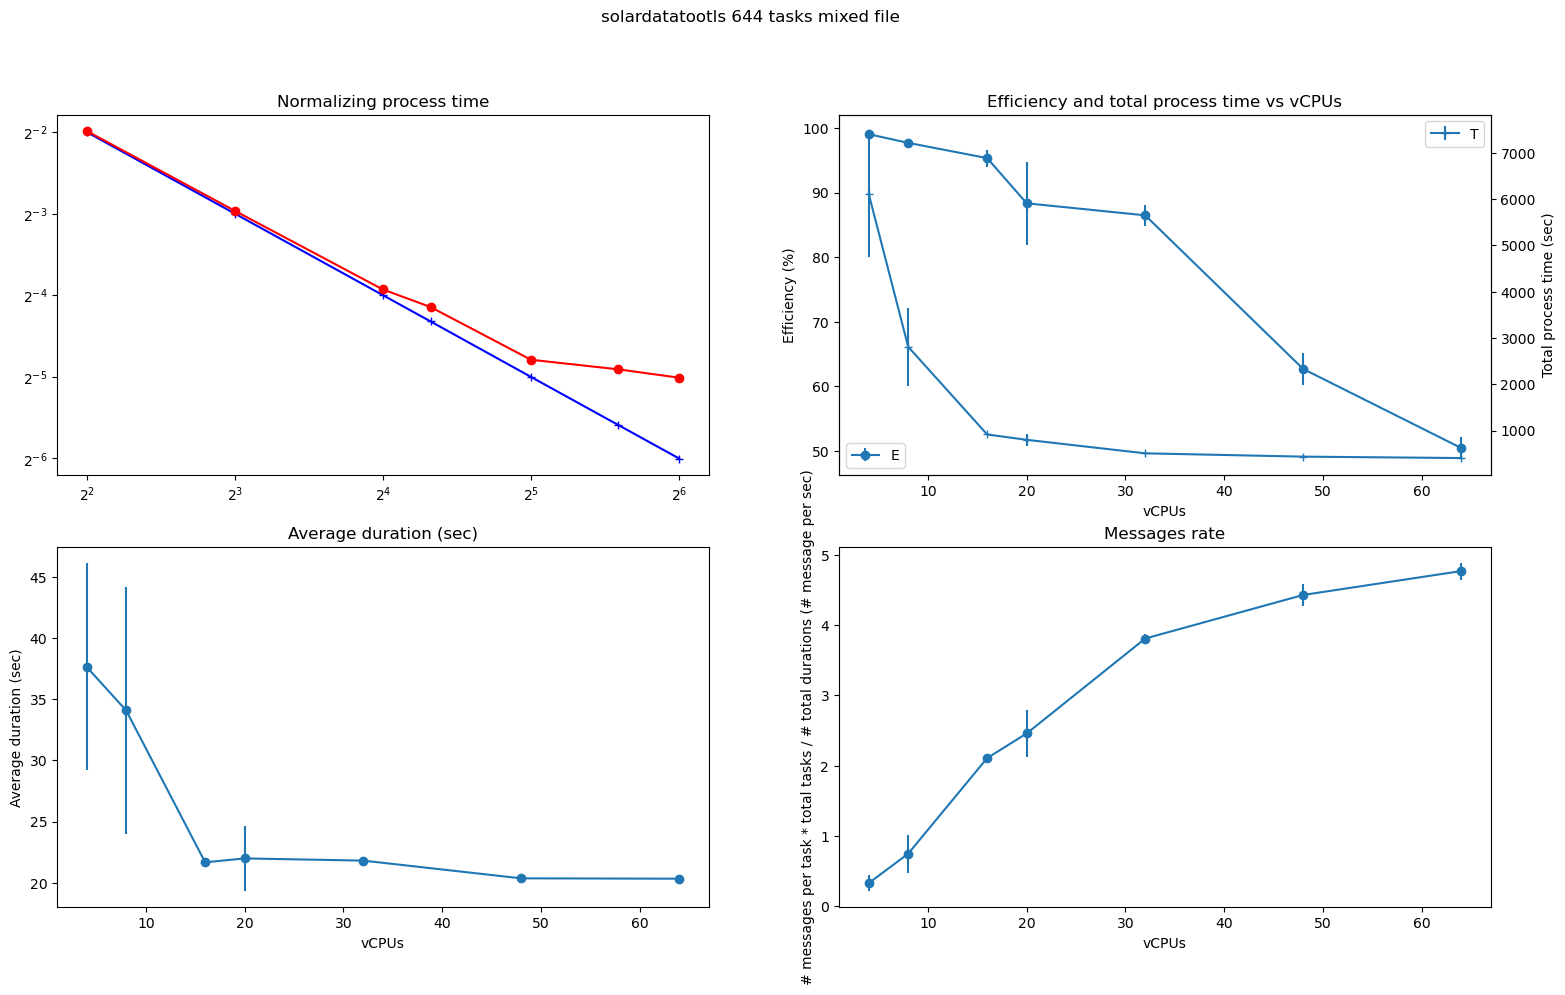

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=False, sharey=False)
fig.set_size_inches(18.5, 10.5)
fig.set_dpi(100)
fig.suptitle("solardatatootls 644 tasks mixed file")
datax = [ 10**i for i in range(4,64)]

# ax1.set_yscale('log', base=2)
# ax1.loglog(datax, 20 * np.exp(-t / 10.0))
ax1.set_xscale('log', base=2)
ax1.set_yscale('log', base=2)
ax1.set(title='Normalizing process time')
ax1.plot(X_axis,optimal_normalizing_process_time_list, 'b',marker = '+')
ax1.plot(X_axis,acutal_normalizing_process_time_list, 'r',marker = 'o')

ax2a = ax2.twinx()
ax2.errorbar(X_axis, mean_of_effeciencyFactor_list, yerr=(lower_confidence_interval_of_effeciencyFactor_list, upper_confidence_interval_of_effeciencyFactor_list) ,marker = 'o')
ax2a.errorbar(X_axis, mean_of_task_duration_in_parallelism_list, yerr=(lower_confidence_interval_of_task_duration_in_parallelism, upper_confidence_interval_of_task_duration_in_parallelism),marker = '+' )
ax2.set_title('Efficiency and total process time vs vCPUs')
ax2a.legend("Total process time(s)",loc='upper right')
ax2.legend("Efficiency",loc='lower left')

ax2.set(xlabel='vCPUs', ylabel='Efficiency (%)')
ax2a.set(xlabel='vCPUs', ylabel='Total process time (sec)')

ax3.errorbar(X_axis, mean_of_average_task_duration_list, yerr=(lower_confidence_interval_of_average_task_duration_list, upper_confidence_interval_of_average_task_duration_list) ,marker = 'o')
ax3.set_title('Average duration (sec)')
ax3.set(xlabel='vCPUs', ylabel='Average duration (sec)')


ax4.errorbar(X_axis, mean_of_messages_rate_list, yerr=(lower_confidence_interval_of_messages_rate_list, upper_confidence_interval_of_messages_rate_list) ,marker = 'o')
ax4.set_title('Messages rate')
ax4.set(xlabel='vCPUs', ylabel='# messages per task * total tasks / # total durations (# message per sec)')

plt.show()